# Search for Microlensing events in DP1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import matplotlib.lines as mlines
import itertools
from astropy.coordinates import SkyCoord
import astropy.units as u

from lsst.rsp import get_tap_service
from lsst.daf.butler import Butler
import lsst.afw.display as afw_display
import lsst.sphgeom as sphgeom
import lsst.geom as geom
from lsst.utils.plotting import (get_multiband_plot_colors,
                                 get_multiband_plot_symbols,
                                 get_multiband_plot_linestyles)
import pandas as pd
from scipy.optimize import minimize
import warnings
import weightedstats as ws

In [2]:
service = get_tap_service("tap")
assert service is not None

In [3]:
butler = Butler('dp1', collections="LSSTComCam/DP1")
assert butler is not None

In [4]:
ra_cen = 95.0
dec_cen = -25.0
radius = 1.3
region = sphgeom.Region.from_ivoa_pos(f"CIRCLE {ra_cen} {dec_cen} {radius}")

In [11]:
query = f"""
        SELECT
  fsodo.diaObjectId,
  fsodo.coord_ra,
  fsodo.coord_dec,
  COUNT(*) AS visit_count
FROM dp1.ForcedSourceOnDiaObject AS fsodo
JOIN dp1.Visit AS vis ON fsodo.visit = vis.visit
WHERE
  fsodo.band = 'r'
  AND CONTAINS(
    POINT('ICRS', fsodo.coord_ra, fsodo.coord_dec),
    CIRCLE('ICRS', {ra_cen}, {dec_cen}, {radius})
  ) = 1
GROUP BY
  fsodo.diaObjectId,
  fsodo.coord_ra,
  fsodo.coord_dec
HAVING
  COUNT(*) > 10
"""

In [12]:
job = service.submit_job(query)
job.run()
job.wait(phases=['COMPLETED', 'ERROR'])
print('Job phase is', job.phase)
if job.phase == 'ERROR':
    job.raise_if_error()
assert job.phase == 'COMPLETED'

Job phase is COMPLETED


In [7]:
objtab = job.fetch_result().to_table()

In [8]:
objtab

diaObjectId,coord_ra,coord_dec,visit_count
,deg,deg,
int64,float64,float64,int64
612929079095591015,95.35106829445591,-25.37793186077392,13
612929079095591016,95.34537176082017,-25.3833221054763,12
612929079095591020,95.34455128915458,-25.374719726462157,14
612929079095591042,95.36048153017475,-25.37850149395651,11
612929079095591044,95.36401719112106,-25.370411424876227,11
612929079095591045,95.34602212994777,-25.381846125982747,12
612929079095591051,95.34984478567934,-25.388789793858155,11
612929079095591114,95.35043614114677,-25.37910092937183,13


In [13]:
# ATOUSHA'S IMPLEMENTATION OF THE KMTNet DETECTION ALGORITHM
def run_kmtnet_fit(times, fluxes, flux_errors):

    """
    Fit a two-parameter PSPL (KMTNet-Algorithm) model to a light curve,
    using a grid search over t0 and t_eff,
    and return Delta_Chi2 along with best-fit parameters.
    """

    # Ensure inputs are numpy arrays
    times = np.asarray(times)
    fluxes = np.asarray(fluxes)
    flux_errors = np.asarray(flux_errors)

    # Filter out NaNs from input data before creating DataFrame
    valid_data_indices = ~np.isnan(times) & ~np.isnan(fluxes) & ~np.isnan(flux_errors) & (flux_errors > 0)
    times, fluxes, flux_errors = times[valid_data_indices], fluxes[valid_data_indices], flux_errors[valid_data_indices]

    if len(times) < 5: # KMTNet fit needs sufficient data points
        return None, None, None # Not enough data for KMTNet fit

    data_df = pd.DataFrame({
        'time': times,
        'flux': fluxes,
        'flux_err': flux_errors
    })

    # --- Model Definitions ---
    # Functions for high and low magnification regimes,
    # params: (t, f_1, f_0, t0, t_eff)
    
    def Ft_high(t, f_1, f_0, t0, t_eff):
        # High-mag analytic approximation 
        Q = 1 + ((t - t0) / t_eff)**2
        return np.abs(f_1) * (Q**(-1.0 / 2)) + np.abs(f_0)

    def Ft_low(t, f_1, f_0, t0, t_eff):
         # Low-mag analytic approximation
        Q = 1 + ((t - t0) / t_eff)**2
        return np.abs(f_1) * (1 - (1 + Q / 2)**-2)**(-1.0 / 2) + np.abs(f_0)

     # --- Chi2 Functions for Minimization ---
    def chi2_high(f_params, t, flux, flux_err, t0, teff):
        # Compute chi^2 for the high-mag model (minimize over f1, f0)
        f_1, f_0 = f_params
        model = Ft_high(t, f_1, f_0, t0, teff)
        inv_sigma2 = 1.0 / (flux_err**2)
        return np.sum((flux - model)**2 * inv_sigma2)

    def chi2_low(f_params, t, flux, flux_err, t0, teff):
        # Compute chi^2 for the low-mag model
        f_1, f_0 = f_params
        model = Ft_low(t, f_1, f_0, t0, teff)
        inv_sigma2 = 1.0 / (flux_err**2)
        return np.sum((flux - model)**2 * inv_sigma2)

    # --- Grid Search: Build t0-teff grid for nonlinear fitting ---
    teff_min, teff_max = 1, 100
    teff_list, t0_tE_list = [], []
    current_teff = teff_min

    # Build teff grid (teff_{k+1} = (1 + delta) * teff_k)
    while current_teff <= teff_max:
        teff_list.append(current_teff)
        delta = 1/5 if current_teff < 1 else 1/3
        current_teff *= (1 + delta)

    # For each teff, build the grid of t0 values
    t0_min, t0_max = np.min(times), np.max(times)
    for teff in teff_list:
        t0_current = t0_min
        while t0_current <= t0_max:
            t0_tE_list.append([t0_current, teff])
            delta = 1/5 if teff < 1 else 1/3
            t0_current += delta * teff

    # If no grid was produced, exit
    if not t0_tE_list: return None, None, None


    # --- Main Grid Fit Loop ---
    param1, param2 = [], []  # Will store fit results for high and low mag regimes
    f_initial = [0.01, 0.99] # Initial guess for f_1, f_0

    for i, (t0_val, teff_val) in enumerate(t0_tE_list):
        # For each grid point, select data within the relevant window (t0 ± 7 teff)
        df_i = data_df[(data_df['time'] > (t0_val - 7 * teff_val)) & (data_df['time'] < (t0_val + 7 * teff_val))]

        if len(df_i) < 10:
            continue # Skip if not enough data in interval

        # Prepare arguments for minimize (t, flux, flux_err, t0_val, teff_val)
        args = (df_i['time'].values, df_i['flux'].values, df_i['flux_err'].values, t0_val, teff_val)

        try:
            # Fit the high-magnification model for current grid point
            result1 = minimize(chi2_high, f_initial, args=args, method='BFGS')
            # Compute chi2 for the entire dataset using best-fit parameters
            model_diff1 = data_df['flux'].values - Ft_high(data_df['time'].values, result1.x[0], result1.x[1], t0_val, teff_val)
            chi2_all1 = np.sum((model_diff1)**2 * (1.0 / (data_df['flux_err'].values**2)))


            # Fit the low-magnification model
            result2 = minimize(chi2_low, f_initial, args=args, method='BFGS')
            model_diff2 = data_df['flux'].values - Ft_low(data_df['time'].values, result2.x[0], result2.x[1], t0_val, teff_val)
            chi2_all2 = np.sum((model_diff2)**2 * (1.0 / (data_df['flux_err'].values**2)))

            # Store: [index, t0, teff, f1, f0, local_chi2, window_npts, global_chi2, npts]
            param1.append([i, t0_val, teff_val, result1.x[0], result1.x[1], result1.fun,
                            len(df_i), chi2_all1, len(data_df)])
            param2.append([i, t0_val, teff_val, result2.x[0], result2.x[1], result2.fun,
                            len(df_i), chi2_all2, len(data_df)])
        except Exception as e:
            # If optimization fails, print a warning but continue
            print(f"Warning: KMTNet minimize failed for iteration {i}: {e}")
            continue 

    # If no fits were successful, exit
    if not param1 and not param2: return None, None, None 

    # --- Select Best-fit Parameters ---
    # Find best fits: lowest chi2 on entire dataset for both regimes
    min_value1 = min(param1, key=lambda x: x[7])
    min_value2 = min(param2, key=lambda x: x[7])

    # Use the regime (high or low mag) with the best global chi2
    if min_value1 < min_value2:
              min_value = min_value1
              param = param1
              F_t = Ft_high
              which_regim = 'high'

    else:
              min_value = min_value2
              param = param2
              F_t = Ft_low
              which_regim = 'low'

    # Extract the precise parameters where chi2 is minimized
    for sublist in param:
        if sublist[7] == min_value[7]:
            parameter = sublist



    chi_mlens = parameter[7] # Minimum chi2 for microlensing fit
    t0 = parameter[1]
    t_eff = parameter[2]
    f1 = parameter[3]
    f0 = parameter[4]

    # --- Linear Fit for Flat Model ---
    # Fit a constant flux to the light curve in the same window
    data_df_interval = data_df[(data_df['time'] > (t0 - 7 * t_eff)) & (data_df['time'] < (t0 + 7 * t_eff))]

    if len(data_df_interval) == 0:
        # Fallback to global mean if window is empty
        mean_flux_interval = np.mean(data_df['flux'].values)
    else:
        # Ensure weights are valid (not zero or inf)
        weights = 1.0 / (data_df_interval['flux_err'].values**2)
        valid_weights_indices = ~np.isinf(weights) & ~np.isnan(weights) & (weights > 0)
        if np.sum(valid_weights_indices) > 0:
            mean_flux_interval = ws.weighted_mean(data_df_interval['flux'].values[valid_weights_indices],
                                                  weights[valid_weights_indices])
        else:
            mean_flux_interval = np.mean(data_df['flux'].values)

    # Compute chi2 for flat line fit
    chi2_linearfit = np.sum((data_df['flux'] - mean_flux_interval)**2 / (data_df['flux_err']) ** 2)


     # --- Compute Metric and Return ---
    if chi2_linearfit == 0:
        delta_chi_squared_kmt = 0
    else:
        delta_chi_squared_kmt = (abs(chi_mlens - chi2_linearfit) / chi2_linearfit)

    # Return: delta chi2, best-fit physical params
    # If delta_chi_squared_kmt > 0.9, the light curve would be a microlensing candidate.
    return delta_chi_squared_kmt, (t0, t_eff, f1, f0)


Searching at coords: 95.35106829445591  -25.37793186077392 'COMPLETED'
 -> Found 13 r-band observations
Extracting lightcurve for 612929079095591015


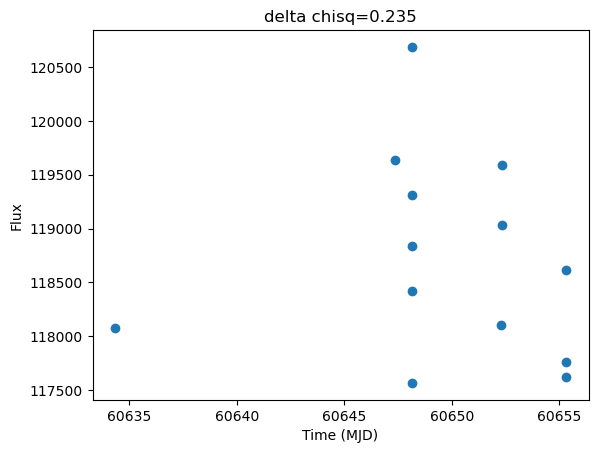

Searching at coords: 95.34537176082017  -25.3833221054763 'COMPLETED'
 -> Found 12 r-band observations
Extracting lightcurve for 612929079095591016


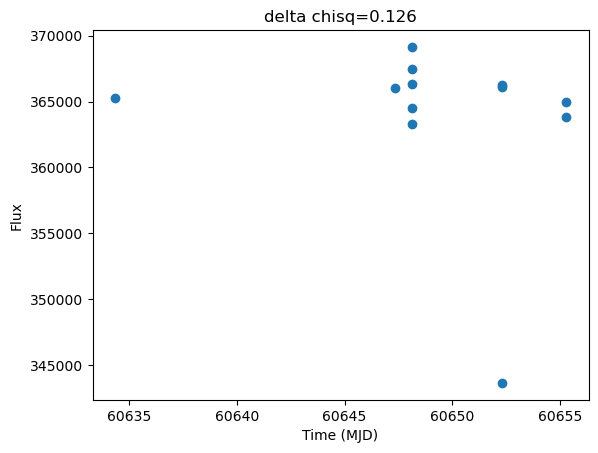

Searching at coords: 95.34455128915458  -25.374719726462157 'COMPLETED'
 -> Found 14 r-band observations
Extracting lightcurve for 612929079095591020


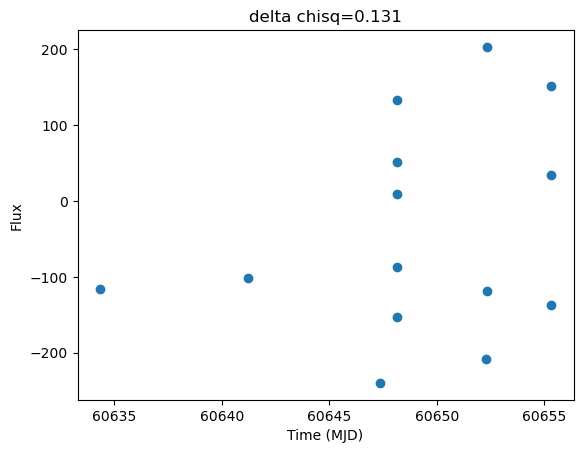

In [ ]:
target_radius = 0.5 / 3600.0  # degrees

with open('./mulens_candidates.dat', 'w') as fout:
    fout.write('# diaObjectId   coord_ra  coord_dec  delta_chi_squared_kmt  t0  t_eff  f1  f0\n')

    i = 0
    maxi = len(objtab)
    while i < maxi:  
        target = objtab[i]
        
        query = f"""
            SELECT fsodo.diaObjectId, fsodo.coord_ra, fsodo.coord_dec,
                   fsodo.visit, fsodo.detector, fsodo.band,
                   fsodo.psfDiffFlux, fsodo.psfDiffFluxErr,
                   fsodo.psfFlux AS psfFlux, fsodo.psfFluxErr,
                   vis.expMidptMJD
            FROM dp1.ForcedSourceOnDiaObject AS fsodo
            JOIN dp1.Visit AS vis ON vis.visit = fsodo.visit
            WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec),
                           CIRCLE('ICRS', {target['coord_ra']}, {target['coord_dec']}, {target_radius})) = 1
        """

        job = service.submit_job(query)
        job.run()
        job.wait(phases=['COMPLETED', 'ERROR'])

        print(f"Searching at coords: {target['coord_ra']}  {target['coord_dec']} {repr(job.phase)}")
        if job.phase == 'ERROR':
            job.raise_if_error()
        assert job.phase == 'COMPLETED'

        forced_sources = job.fetch_result().to_table()
        print(' -> Found', np.sum(forced_sources['band'] == 'r'), 'r-band observations')

        if len(forced_sources) > 0:
            rband = np.where(forced_sources['band'] == 'r')
            if len(rband[0]) < 10:  #skip poor light curves
                i += 1
                continue

            times = forced_sources[rband]['expMidptMJD']
            fluxes = forced_sources[rband]['psfFlux']
            flux_err = forced_sources[rband]['psfFluxErr']

            plt.figure(i)
            plt.scatter(times, fluxes)
            

            print(f'Extracting lightcurve for {target["diaObjectId"]}')

            delta_chi_squared_kmt, (t0, t_eff, f1, f0) = run_kmtnet_fit(times, fluxes, flux_err)

            plt.title('delta chisq='+str(np.round(delta_chi_squared_kmt, 3)))
            plt.ylabel('Flux')
            plt.xlabel('Time (MJD)')
            plt.show()

            if delta_chi_squared_kmt > 0.9:
                fout.write(f"{target['diaObjectId']}  {target['coord_ra']}  {target['coord_dec']}  "
                           f"{delta_chi_squared_kmt}  {t0}  {t_eff}  {f1}  {f0}\n")

        i += 1
        if i == 10:
            break